In [3]:
import preprocessing.preprocessing as pp
import torch
from models import nodeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from visualization import mesh_viewer
import evaluation.evaluation as ev
import graph_matching.graph_matching as gm
import graph_matching.graph_connection as gc
import training.training as tt
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from scipy import stats
import pyvista

import tifffile as tiff
import networkx as nx
from torch_geometric.utils.convert import from_networkx

# Create the graph from the combined masks and assign labels to it

In [4]:
# creating the graph
nodesFileComb =  "~/Documents/Intestine/combined-mask/nodes_bs2_fh_upsamp.csv"
edgesFileComb = "~/Documents/Intestine/combined-mask/edges_bs2_fh_upsamp.csv"

nodes_c = pd.read_csv(nodesFileComb, sep = ";", index_col= "id")
edges_c = pd.read_csv(edgesFileComb, sep = ";", index_col= "id")

# scaling with the factors provided by luciano
#nodes_c = pp.scalePosition(nodes_c, (1.625,1.625,6))

# creating the graph
G_comb = pp.createGraph(nodes_c, edges_c)
G_comb_einf = pp.convertToEinfach(G_comb, self_loops = False, isolates = False)

### Assign the labels based on the masks

In [5]:
# base the classifcation on the mask labels at the position of the nodes
nerve_mask =  "../Intestine/nerve-mask/nerve_mask_stack_255_fh_upsamp.tif"
lymph_mask =  "../Intestine/lymph-mask/lymph_mask_stack_255_fh_upsamp.tif"

# read tif and convert to numpy 
nerve_mask_np = np.array(tiff.imread(nerve_mask)).T
lymph_mask_np = np.array(tiff.imread(lymph_mask)).T

# extracting the labels for the graph
mask_labels_num = gm.assignNodeLabelsByMask([nerve_mask_np, lymph_mask_np], G = G_comb_einf, voxel_size= (0.00217391,0.00217391,0.00217391), scaling_vector= (1, 1, 1), kernel_size=9) # (0.00217391,0.00217391,0.00217391)

# create dictionary to convert int labels to char labels
char_class_reverse = {}
char_class_reverse[0] = "n"
char_class_reverse[1] = "l"

# create a copy that will be used for relabeling
mask_labels = mask_labels_num.copy()

# adjust the node names
for key in mask_labels:
    mask_labels[key] = str(key) + char_class_reverse[mask_labels[key]]

# relabel the graph with the mask based labeling
G_comb_einf_lab = nx.relabel_nodes(G_comb_einf, mask_labels)
nx.write_gpickle(G_comb_einf_lab, "saved_data/graph_gt_pickle_upsamp")

# check if all the masks have a label (otherwise class -1 exists)
np.unique(list(mask_labels_num.values()), return_counts = True)


100%|██████████| 4375/4375 [00:00<00:00, 29397.80it/s]


(array([0, 1]), array([1592, 2783]))

In [28]:
y_pos = [G_comb_einf.nodes[node]["pos"][1] for node in G_comb_einf.nodes()]
y_pos_sorted = sorted(y_pos)

x_pos = [G_comb_einf.nodes[node]["pos"][0] for node in G_comb_einf.nodes()]
z_pos = [G_comb_einf.nodes[node]["pos"][2] for node in G_comb_einf.nodes()]

print(max(x_pos))
print(min(x_pos))

print(max(y_pos))
print(min(y_pos))

print(max(z_pos))
print(min(z_pos))


y_pos_sorted[int(len(y_pos_sorted)*0.8)]

0.980435
-0.995652
0.680435
-0.678261
0.515217
-0.517391


0.402899

### Visualize the graph

Dual graph from combined extraction with mask based labeling.


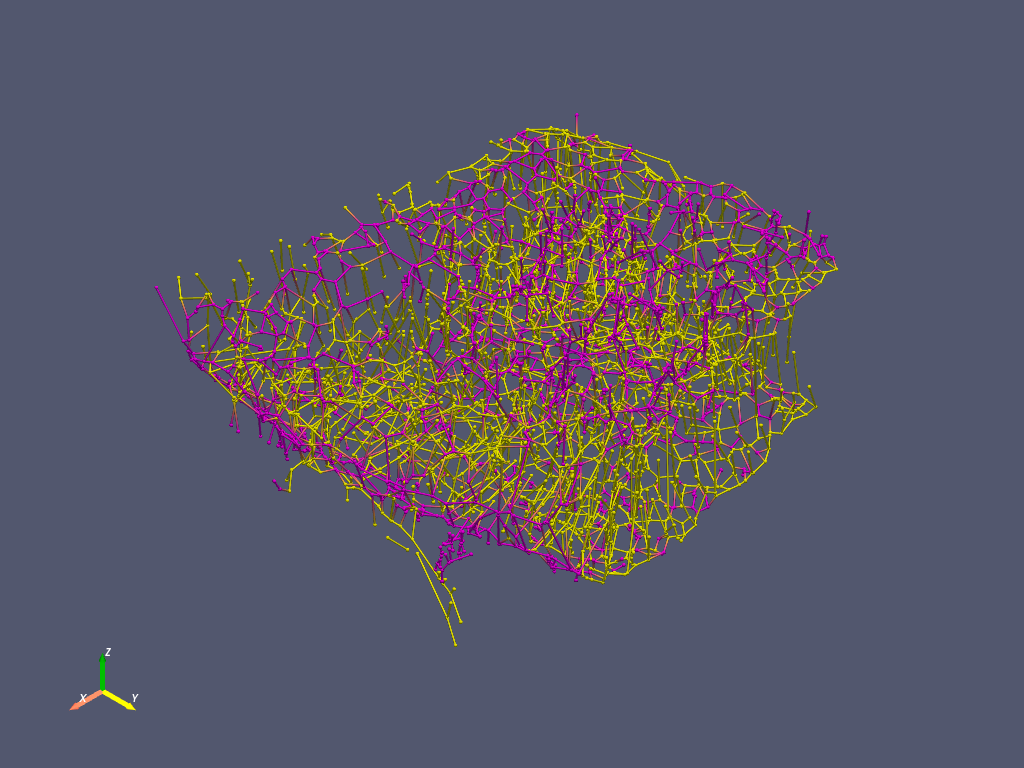

In [29]:
print("Dual graph from combined extraction with mask based labeling.")
mesh_viewer.renderNXGraph(G_comb_einf_lab, dual = False, vtk = 0,backend = "static")

### Create and visualize the dual graph

Dual graph from combined extraction with mask based labeling.


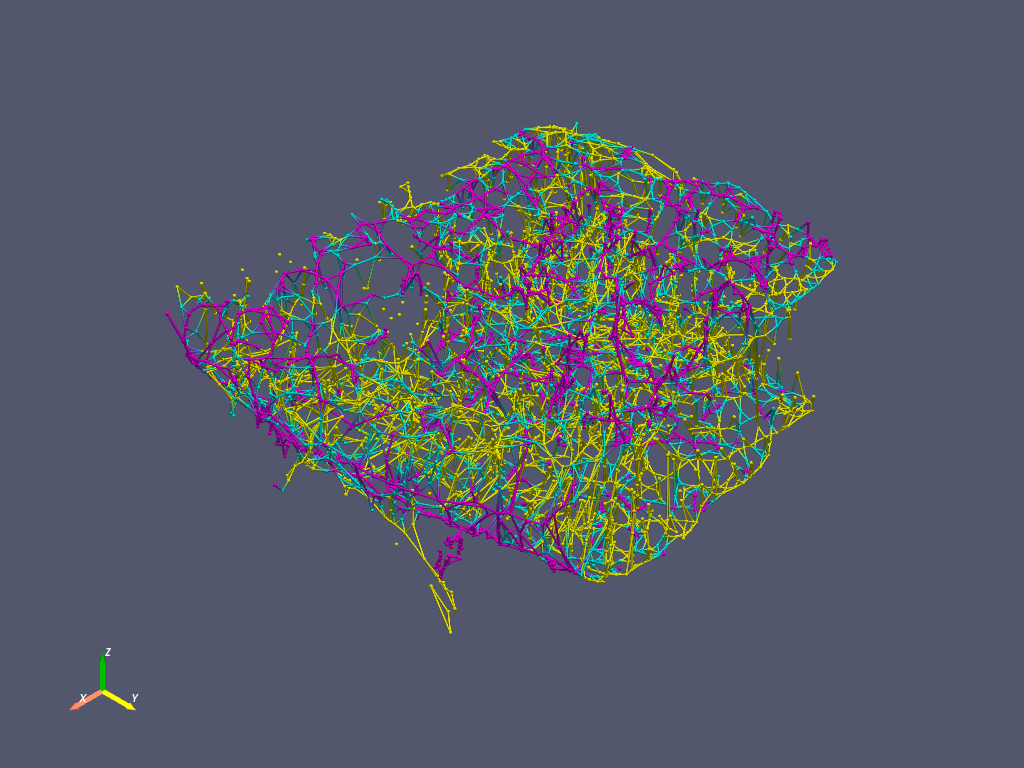

In [7]:
L_comb_einf_lab = pp.makeDual(G_comb_einf_lab, include_orientation= False)
print("Dual graph from combined extraction with mask based labeling.")
mesh_viewer.renderNXGraph(L_comb_einf_lab, dual = True, vtk = 0, backend = "static")

# Start playing with models for node classification

In [15]:
# loading potential architectures
netGCN = nodeClassifier.GCN_VS
netSAGE = nodeClassifier.SAGE_VS
netGAT = nodeClassifier.GAT_VS

### Classification on G

In [32]:
# enrich nodes with information form edges
pp.enrichNodeAttributes(G_comb_einf_lab)
GX_comb_einf_lab = from_networkx(G_comb_einf_lab)
GX_comb_einf_lab.y = torch.tensor(list(mask_labels_num.values()))


# extract the classes and features for model input
num_feat_comb = GX_comb_einf_lab.x.shape[1]
num_class_comb = len(np.unique(GX_comb_einf_lab.y))


# create a network arch
SAGE1 = nodeClassifier.nodeClassifier(netSAGE, 64, features = np.arange(num_feat_comb), classes = num_class_comb, num_layers= 4,  lr = 0.00134, weight_decay= 0.0002) 

# create a trainer for the model
# this way a random split is done
SAGE1_TR = tt.Trainer(SAGE1,GX_comb_einf_lab)


# create a trainer with slicing by z axis 
# slicing along any other axis than y does not really make sense - y slicing goes along the path of the intestine

SAGE1_TR_y = tt.Trainer(SAGE1,GX_comb_einf_lab, split= (0,1,0))


100%|██████████| 10/10 [00:00<00:00, 11.28it/s]


Total number of epochs: 10


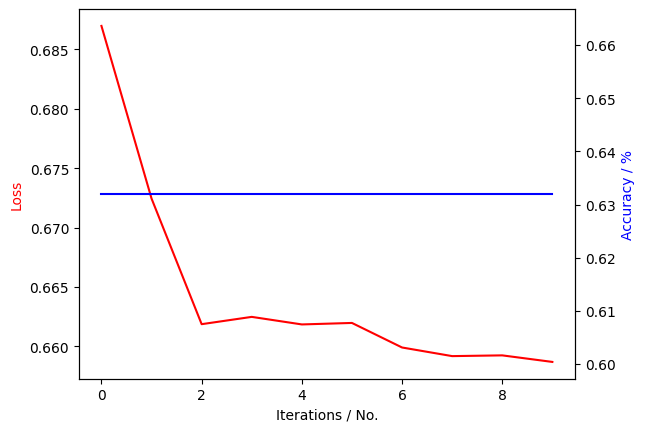

In [33]:
# train the model for a given number of epochs
loss_l, acc_l = SAGE1_TR.trainXepochs(10)

# total number of training epoch for this model
print("Total number of epochs: " + str(SAGE1_TR.totalEpoch))

# plot the loss and val acc over the epochs
ev.plot_loss_acc(loss_l, acc_l)

Validation set accuracy:  0.6320
Train set accuracy: 0.6371
Validation set balanced accuracy:  0.5000
Train set balanced accuracy: 0.5000


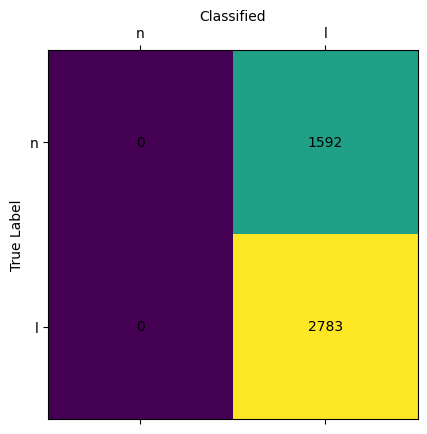

In [34]:
full_mask_comb = torch.tensor(np.arange(0, GX_comb_einf_lab.y.shape[0]))
pred_whole_comb = SAGE1_TR.model.predictions(GX_comb_einf_lab)
pred_whole_comb_acc = SAGE1_TR.model.test(GX_comb_einf_lab, full_mask_comb)


print(f"Validation set accuracy:  {accuracy_score(SAGE1_TR.nxGraph.y[SAGE1_TR.test_mask], pred_whole_comb[SAGE1_TR.test_mask]):.4f}")
print(f"Train set accuracy: {accuracy_score(SAGE1_TR.nxGraph.y[SAGE1_TR.train_mask], pred_whole_comb[SAGE1_TR.train_mask]):.4f}")

print(f"Validation set balanced accuracy:  {balanced_accuracy_score(SAGE1_TR.nxGraph.y[SAGE1_TR.test_mask], pred_whole_comb[SAGE1_TR.test_mask]):.4f}")
print(f"Train set balanced accuracy: {balanced_accuracy_score(SAGE1_TR.nxGraph.y[SAGE1_TR.train_mask], pred_whole_comb[SAGE1_TR.train_mask]):.4f}")
ev.plot_confusion_matrix(np.array(SAGE1_TR.nxGraph.y), pred_whole_comb, char_class_reverse.values())


# somehow this bugs
#rocL_comb = ev.eval_roc_auc(GX_comb_einf_lab.y, SAGE1_TR.model.predictions(GX_comb_einf_lab, max_prob = False))
#print("ROC AUC: " + str(rocL_comb))


### Classification on L

In [47]:
LX_comb_einf_lab = from_networkx(L_comb_einf_lab)
class_label_list, node_lab, node_lab_explain =  pp.getLablesForDual(L_comb_einf_lab)

y_dict_L_comb_einf_lab = dict(zip(list(L_comb_einf_lab.nodes()), class_label_list))
nx.set_node_attributes(L_comb_einf_lab,y_dict_L_comb_einf_lab, "y")

# assign the ground truth class information to the torch data obj
LX_comb_einf_lab.y = torch.tensor(class_label_list)


xL_data = LX_comb_einf_lab.x.detach().numpy()


degs_np = np.array(list(L_comb_einf_lab.degree()))[:,1]
triangs_np = np.array(list(nx.triangles(L_comb_einf_lab).values()))

#introduce more features:

rel_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,15]

new_data = np.zeros((xL_data.shape[0], len(rel_idx)+2))

new_data[:,:len(rel_idx)] = xL_data[:, rel_idx]

new_data[:,len(rel_idx)] = degs_np
new_data[:,len(rel_idx)+1] = triangs_np

new_data = (new_data - np.mean(new_data, axis = 0)) / np.std(new_data, axis = 0)

#new_data = (new_data - np.median(new_data
# normalize the features 
#xL_data = LX_comb_einf_lab.x.detach().numpy()
#xL_data = xL_data[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,15]]
#xL_data = (xL_data - np.median(xL_data, axis = 0)) / stats.median_abs_deviation(xL_data, axis = 0, scale = "normal")
#xL_data = (xL_data - xL_data.min(0)) / xL_data.ptp(0)
#np.nan_to_num(xL_data, copy = False)
#LX_comb_einf_lab.x = torch.tensor(xL_data[:,:-1])
LX_comb_einf_lab.x = torch.tensor(new_data)



# extract the number of classes and features for model input
num_feat_dual_comb = LX_comb_einf_lab.x.shape[1]
num_class_dual_comb = len(np.unique(LX_comb_einf_lab.y))

print(num_feat_dual_comb)
print(num_class_dual_comb)

# create a network arch
SAGE1L = nodeClassifier.nodeClassifier(netSAGE, 64, features = np.arange(num_feat_dual_comb), classes = num_class_dual_comb, num_layers= 8,  lr = 0.009076, weight_decay= 0.0001999) # prev  lr = 0.00542, weight_decay= 0.0001985


# create a trainer for the model
SAGE1L_TR = tt.Trainer(SAGE1L,LX_comb_einf_lab)

# create a network arch
GAT1L = nodeClassifier.nodeClassifier(netGAT, 64, features = np.arange(num_feat_dual_comb), classes = num_class_dual_comb, num_layers= 8,  lr = 0.019076, weight_decay= 0.0001999)

# create a trainer for the model
GAT1L_TR = tt.Trainer(GAT1L,LX_comb_einf_lab)



16
3


/tmp/ipykernel_4239/2369503059.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  degs_np = np.array(list(L_comb_einf_lab.degree()))[:,1]


In [36]:
print(LX_comb_einf_lab.x)

tensor([[ 1.0017,  0.5273,  5.0184,  ..., -1.1259,  0.2652,  1.1037],
        [-0.2218, -0.3184,  1.7770,  ..., -0.6285, -0.8559, -0.2453],
        [-0.1656, -0.1528,  0.1280,  ..., -0.7756,  0.4790, -0.1226],
        ...,
        [-0.4967, -0.4434, -1.0337,  ..., -0.2400, -0.3357, -0.5519],
        [ 1.4747,  1.4162,  1.2391,  ..., -1.2069, -0.3494,  1.5329],
        [ 0.2748, -0.1247,  5.9780,  ..., -0.2944,  1.4289,  0.2453]],
       dtype=torch.float64)


100%|██████████| 10/10 [00:02<00:00,  4.67it/s]

Total number of epochs: 10


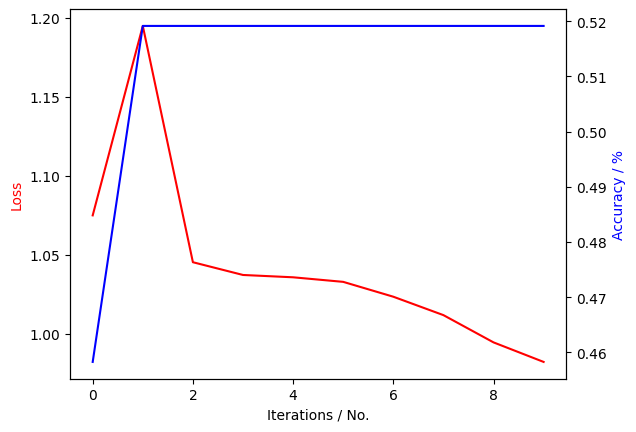

In [37]:
# train the model for a given number of epochs
loss_l, acc_l = SAGE1L_TR.trainXepochs(10)

# total number of training epoch for this model
print("Total number of epochs: " + str(SAGE1L_TR.totalEpoch))

# plot the loss and val acc over the epochs
ev.plot_loss_acc(SAGE1L_TR.loss_l, SAGE1L_TR.acc_l)

In [14]:
# train the model for a given number of epochs
#loss_l, acc_l = GAT1L_TR.trainXepochs(500, verbose = True)

# total number of training epoch for this model
#print("Total number of epochs: " + str(GAT1L_TR.totalEpoch))

# plot the loss and val acc over the epochs
#ev.plot_loss_acc(GAT1L_TR.loss_l, GAT1L_TR.acc_l)

Validation set accuracy:  0.2637
Train set accuracy: 0.2897
Validation set balanced accuracy:  0.3333
Train set balanced accuracy: 0.3333


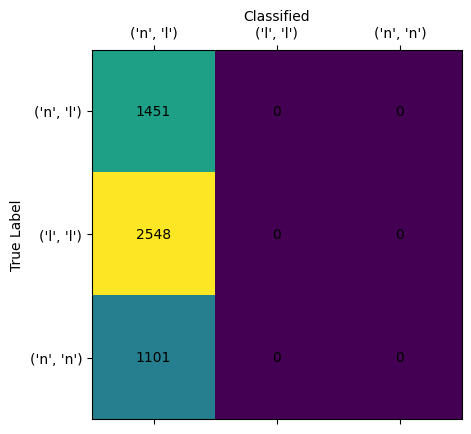

ValueError: Input contains NaN.

In [49]:
full_mask_dual_comb = torch.tensor(np.arange(0, LX_comb_einf_lab.y.shape[0]))
pred_whole_comb = SAGE1L_TR.model.predictions(LX_comb_einf_lab)
pred_whole_comb_acc = SAGE1L_TR.model.test(LX_comb_einf_lab, full_mask_dual_comb)


print(f"Validation set accuracy:  {accuracy_score(SAGE1L_TR.nxGraph.y[SAGE1L_TR.test_mask], pred_whole_comb[SAGE1L_TR.test_mask]):.4f}")
print(f"Train set accuracy: {accuracy_score(SAGE1L_TR.nxGraph.y[SAGE1L_TR.train_mask], pred_whole_comb[SAGE1L_TR.train_mask]):.4f}")

print(f"Validation set balanced accuracy:  {balanced_accuracy_score(SAGE1L_TR.nxGraph.y[SAGE1L_TR.test_mask], pred_whole_comb[SAGE1L_TR.test_mask]):.4f}")
print(f"Train set balanced accuracy: {balanced_accuracy_score(SAGE1L_TR.nxGraph.y[SAGE1L_TR.train_mask], pred_whole_comb[SAGE1L_TR.train_mask]):.4f}")
ev.plot_confusion_matrix(np.array(SAGE1L_TR.nxGraph.y), pred_whole_comb, node_lab_explain.values())


# somehow this bugs
rocL_comb = ev.eval_roc_auc(LX_comb_einf_lab.y, SAGE1L_TR.model.predictions(LX_comb_einf_lab, max_prob = False))
print("ROC AUC: " + str(rocL_comb))


In [16]:
# save the model parameters
#torch.save(SAGE1L_TR.model.model.state_dict(), "saved_data/bestDualModel")


mLoad = nodeClassifier.SAGE_VS(in_channels = num_feat_dual_comb,hidden_channels= 64,out_channels = num_class_dual_comb, num_layers= 8, dropout = 0.5)
mLoad.load_state_dict(torch.load("saved_data/bestDualModel"))


# set the parameters to the safed ones
SAGE1L_TR.model.model = mLoad

Validation set accuracy:  0.5137
Train set accuracy: 0.4951
Validation set balanced accuracy:  0.3356
Train set balanced accuracy: 0.3338


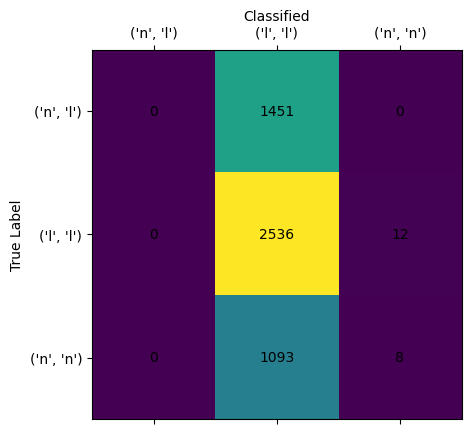

ROC AUC: 0.49544744217501263


In [17]:
full_mask_dual_comb = torch.tensor(np.arange(0, LX_comb_einf_lab.y.shape[0]))
pred_whole_comb = SAGE1L_TR.model.predictions(LX_comb_einf_lab)
pred_whole_comb_acc = SAGE1L_TR.model.test(LX_comb_einf_lab, full_mask_dual_comb)


print(f"Validation set accuracy:  {accuracy_score(SAGE1L_TR.nxGraph.y[SAGE1L_TR.test_mask], pred_whole_comb[SAGE1L_TR.test_mask]):.4f}")
print(f"Train set accuracy: {accuracy_score(SAGE1L_TR.nxGraph.y[SAGE1L_TR.train_mask], pred_whole_comb[SAGE1L_TR.train_mask]):.4f}")

print(f"Validation set balanced accuracy:  {balanced_accuracy_score(SAGE1L_TR.nxGraph.y[SAGE1L_TR.test_mask], pred_whole_comb[SAGE1L_TR.test_mask]):.4f}")
print(f"Train set balanced accuracy: {balanced_accuracy_score(SAGE1L_TR.nxGraph.y[SAGE1L_TR.train_mask], pred_whole_comb[SAGE1L_TR.train_mask]):.4f}")
ev.plot_confusion_matrix(np.array(SAGE1L_TR.nxGraph.y), pred_whole_comb, node_lab_explain.values())


# somehow this bugs
rocL_comb = ev.eval_roc_auc(LX_comb_einf_lab.y, SAGE1L_TR.model.predictions(LX_comb_einf_lab, max_prob = False))
print("ROC AUC: " + str(rocL_comb))


### Finding predicitive structures and features

In [18]:
from torch_geometric.nn import GNNExplainer

node_idx = 100
x, edge_index = LX_comb_einf_lab.x.float(), LX_comb_einf_lab.edge_index
explainer = GNNExplainer(SAGE1L_TR.model.model, epochs=10)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index, training = False)

print(f"Node Class: {LX_comb_einf_lab.y[node_idx]}")

Explain node 100: 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

Node Class: 1


tensor([0.4977, 0.5351, 0.5671, 0.5478, 0.4397, 0.4667, 0.4744, 0.4309, 0.4719,
        0.4523, 0.4629, 0.4914, 0.4490, 0.4912, 0.4864, 0.5635, 0.5286])


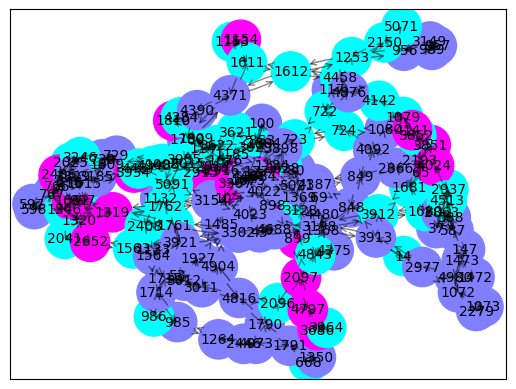

In [19]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=LX_comb_einf_lab.y)
print(node_feat_mask)
plt.show()

### Classify the Graph G based on the learned Classification on L

In [20]:
y_pred = dict(zip(L_comb_einf_lab.nodes(), pred_whole_comb.detach().numpy()))
y_G_gt = dict(zip(G_comb_einf_lab.nodes(), GX_comb_einf_lab.y.detach().numpy()))

conv_dict_G = {0 : "n", 1 : "l"}

for k,v in y_G_gt.items():
    y_G_gt[k] = conv_dict_G[v]


nx.set_node_attributes(G_comb_einf_lab,y_G_gt, "y")
nx.set_node_attributes(G_comb_einf_lab,y_pred, "y_pred")
nx.set_node_attributes(L_comb_einf_lab,y_pred, "y_pred")


conv_dict_L = {0 : "nl", 1 : "l", 2: "n"}

# label by first assigning the single class edges and then iteratively filling up
gm.labelPrimalFromDual(G_comb_einf_lab, L_comb_einf_lab, "y_pred", conv_dict_L, "y_pred_mB")

# label by assigning class that most of the connected edges have
gm.labelPrimalFromDualFreq(G_comb_einf_lab, L_comb_einf_lab, "y_pred", conv_dict_L, "y_pred_mF")



corr = 0
wrong = 0

for k,v in G_comb_einf_lab.nodes.items():
    if v["y"] == v["y_pred_mB"]:
        corr += 1
    else:
        wrong +=1

# check how many of the nodes got assigned the correct label
print("Accuracy on whole G: " +str(corr / (wrong +corr)))


Accuracy on whole G: 0.6457604306864064


### Create the line graph label again

In [21]:
### Classify the Graph G based on the learned Classification on L


for node in L_comb_einf_lab.nodes():
    n1 = node[0]
    n2 = node[1]

    cl1 = G_comb_einf_lab.nodes[n1]["y_pred_mB"] 
    cl2 = G_comb_einf_lab.nodes[n2]["y_pred_mB"] 

    if cl1 == cl2:
        L_comb_einf_lab.nodes[node]["y_pred_R2"] = cl1
    else:
        L_comb_einf_lab.nodes[node]["y_pred_R2"] = "nl"

corr = 0
wrong = 0

for i, v in enumerate(L_comb_einf_lab.nodes.values()):
    gt = conv_dict_L[LX_comb_einf_lab.y.detach().numpy()[i]]
    if gt == v["y_pred_R2"]:
        corr += 1
    else:
        wrong +=1

# check how many of the nodes got assigned the correct label
# obviously does not improve 
print("Accuracy on whole L: " +str(corr / (wrong +corr)))

Accuracy on whole L: 0.4988235294117647


### Split the graph and train/test on different parts of the graph

In [19]:
splitter = tt.Splitter(LX_comb_einf_lab)

train_mask, test_mask, splitValue = splitter.split_geometric((0,1,0), frac = 0.5)

train_list = np.array(list(L_comb_einf_lab.nodes()))[train_mask].tolist()
train_nodes = [(elem[0],elem[1]) for elem in train_list]

test_list = np.array(list(L_comb_einf_lab.nodes()))[test_mask].tolist()
test_nodes = [(elem[0],elem[1]) for elem in test_list]

train_subG = L_comb_einf_lab.subgraph(train_nodes)
test_subG = L_comb_einf_lab.subgraph(test_nodes)

nx.write_gpickle(train_subG, "saved_data/graph_L05_train_gt_pickle_upsamp")
nx.write_gpickle(test_subG, "saved_data/graph_L05_test_gt_pickle_upsamp")


Dual graph only test part.


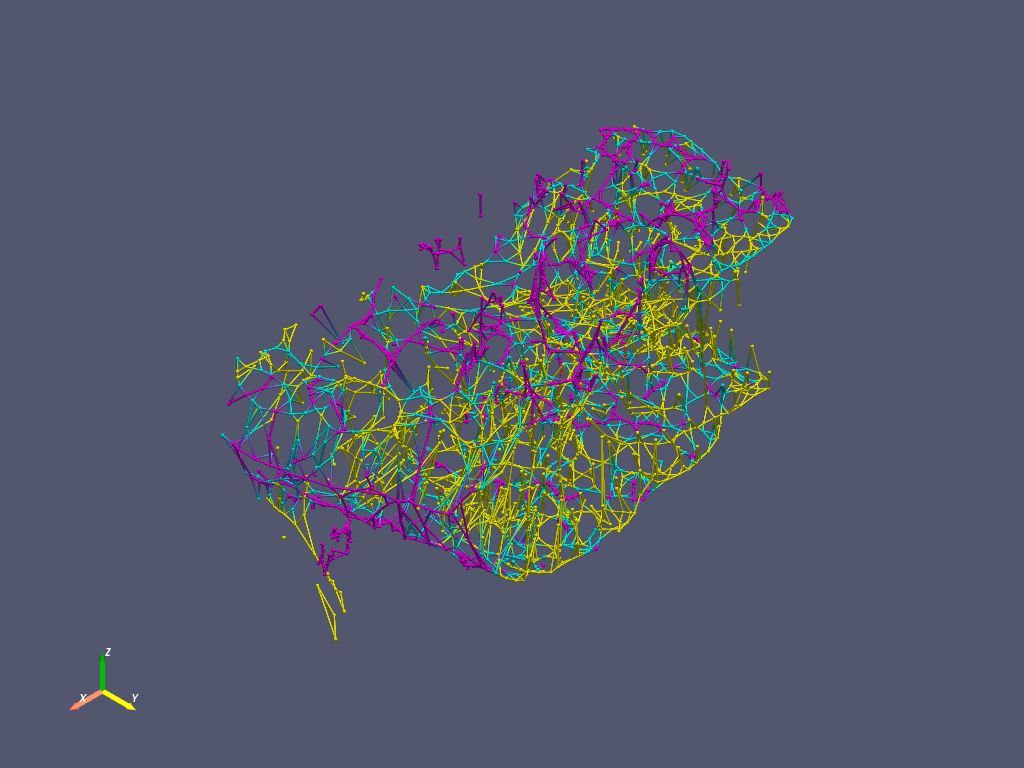

Dual graph only train part.


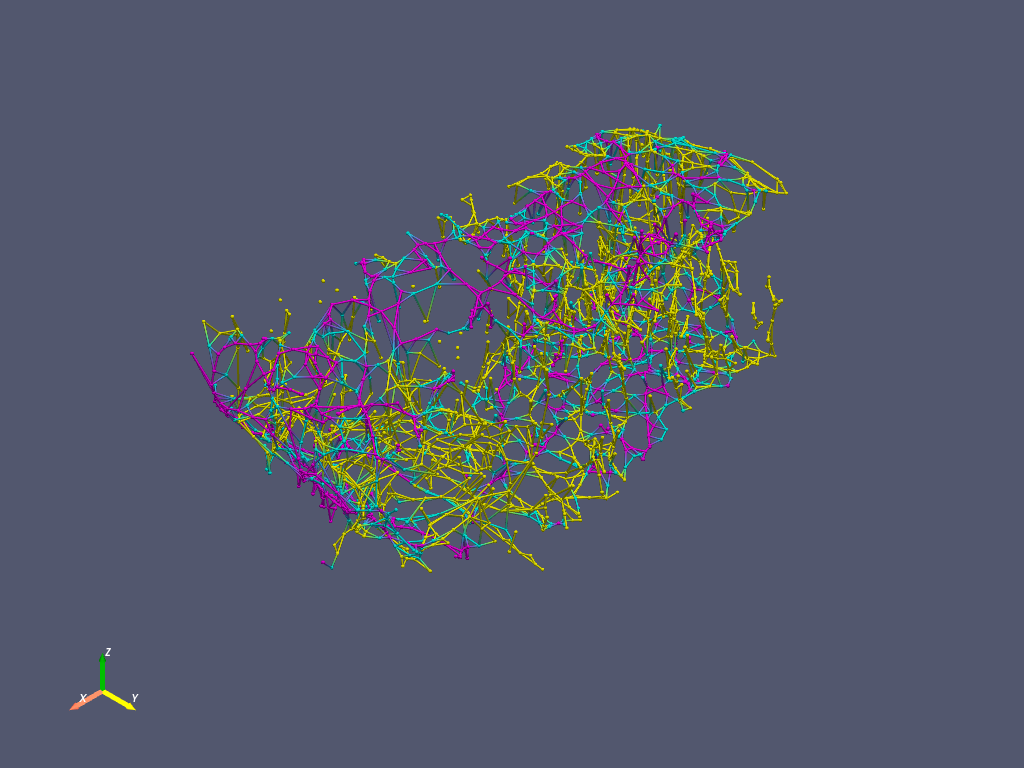

In [20]:
print("Dual graph only test part.")
mesh_viewer.renderNXGraph(test_subG, dual = True, vtk = 0,backend = "static")
print("Dual graph only train part.")
mesh_viewer.renderNXGraph(train_subG, dual = True, vtk = 0,backend = "static")

In [100]:
split_wholeG = nx.union(train_subG, test_subG)

split_wholeG_torch = from_networkx(split_wholeG)
split_wholeG_y, _, _ =  pp.getLablesForDual(split_wholeG, node_lab)

split_wholeG_torch.y = torch.tensor(split_wholeG_y)

geom_train_mask_torch = np.arange(0, train_subG.order())
geom_test_mask_torch = np.arange(train_subG.order(),train_subG.order()+ test_subG.order())

# create the training and testing masks
train_mask_random = np.random.choice(np.arange(0, geom_train_mask_torch.shape[0]), size= int(geom_train_mask_torch.shape[0]*0.85), replace = False)
test_mask_random = np.delete(np.arange(0, geom_train_mask_torch.shape[0]), train_mask_random)


SAGE_geom = nodeClassifier.nodeClassifier(netSAGE, 64, features = np.arange(num_feat_dual_comb), classes = num_class_dual_comb,  num_layers= 4,  lr = 0.00607, weight_decay= 0.000101) 

#SAGE_geom.model = netSAGE(num_feat_dual_comb, 64, num_class_dual_comb, dropout = 0.5, num_layers = 4, MLP = True, skip = True, norm = False, aggr = "std")
#SAGE_geom.optimizer = torch.optim.AdamW(SAGE_geom.model.parameters(), lr= 0.00607, weight_decay= 0.0001871)

from torch_geometric.nn import GCN
from tqdm import tqdm
SAGE_geom.model = netGCN(in_channels = num_feat_dual_comb, hidden_channels= 64, num_layers = 2, out_channels = num_class_dual_comb, dropout = 0.5, MLP = True, skip = True)
SAGE_geom.optimizer = torch.optim.AdamW(SAGE_geom.model.parameters(), lr= 0.00239, weight_decay= 0.0002296)


epochs = 1000
res_arr = np.zeros((epochs,3))
for epoch in tqdm(range(0, epochs)):
    loss = SAGE_geom.train(split_wholeG_torch, train_mask_random)
    res_arr[epoch,0] = loss
    val_acc = SAGE_geom.test(split_wholeG_torch, test_mask_random)
    res_arr[epoch,1] = val_acc
    test_acc = SAGE_geom.test(split_wholeG_torch, geom_test_mask_torch)
    res_arr[epoch,2] = test_acc

    #print(f"Epoch: {1+epoch:03d}, Loss: {loss:.3f}, Val. Acc: {val_acc:.3f}, Test Acc: {test_acc:.3f}")

100%|██████████| 1000/1000 [06:16<00:00,  2.66it/s]


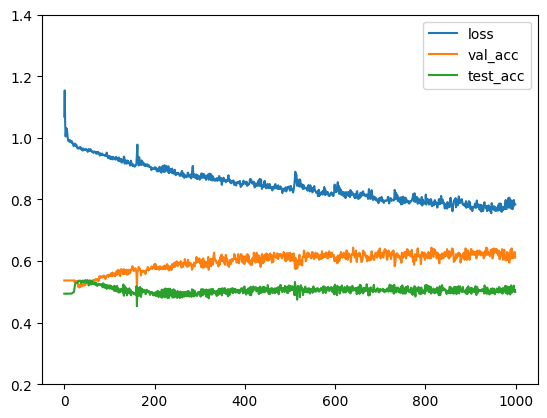

In [101]:
plt.plot(res_arr)
plt.ylim(0.2,1.4)
plt.legend(("loss","val_acc", "test_acc"))
plt.show()

Training accuracy:  0.6486
Training balanced accuracy:  0.5649


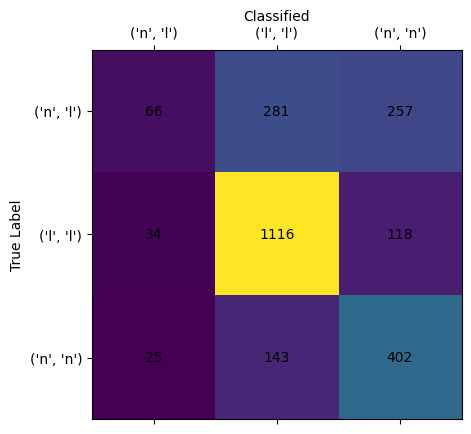

Validation (transductive) accuracy:  0.6111
Validation (transductive) balanced accuracy:  0.5183


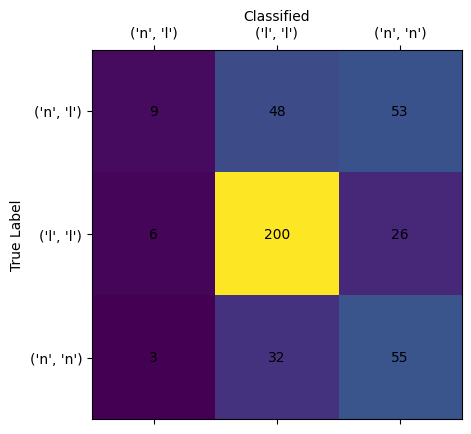

Test (inductive) accuracy:  0.4997
Test (inductive) balanced accuracy:  0.4365


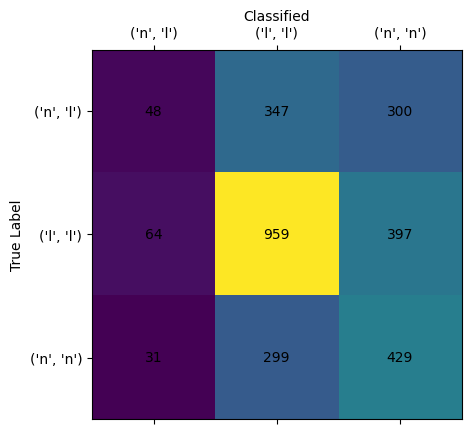

In [104]:
pred_split = SAGE_geom.predictions(split_wholeG_torch)


# train loss
print(f"Training accuracy:  {accuracy_score(split_wholeG_torch.y[train_mask_random], pred_split[train_mask_random]):.4f}")
print(f"Training balanced accuracy:  {balanced_accuracy_score(split_wholeG_torch.y[train_mask_random], pred_split[train_mask_random]):.4f}")
ev.plot_confusion_matrix(np.array(split_wholeG_torch.y[train_mask_random]), pred_split[train_mask_random], node_lab_explain.values())

# validation loss - transductive
print(f"Validation (transductive) accuracy:  {accuracy_score(split_wholeG_torch.y[test_mask_random], pred_split[test_mask_random]):.4f}")
print(f"Validation (transductive) balanced accuracy:  {balanced_accuracy_score(split_wholeG_torch.y[test_mask_random], pred_split[test_mask_random]):.4f}")
ev.plot_confusion_matrix(np.array(split_wholeG_torch.y[test_mask_random]), pred_split[test_mask_random], node_lab_explain.values())

# validation loss - inductive
print(f"Test (inductive) accuracy:  {accuracy_score(split_wholeG_torch.y[geom_test_mask_torch], pred_split[geom_test_mask_torch]):.4f}")
print(f"Test (inductive) balanced accuracy:  {balanced_accuracy_score(split_wholeG_torch.y[geom_test_mask_torch], pred_split[geom_test_mask_torch]):.4f}")
ev.plot_confusion_matrix(np.array(split_wholeG_torch.y[geom_test_mask_torch]), pred_split[geom_test_mask_torch], node_lab_explain.values())

### Try to visualize the created node embedding for the training, validation and test nodes

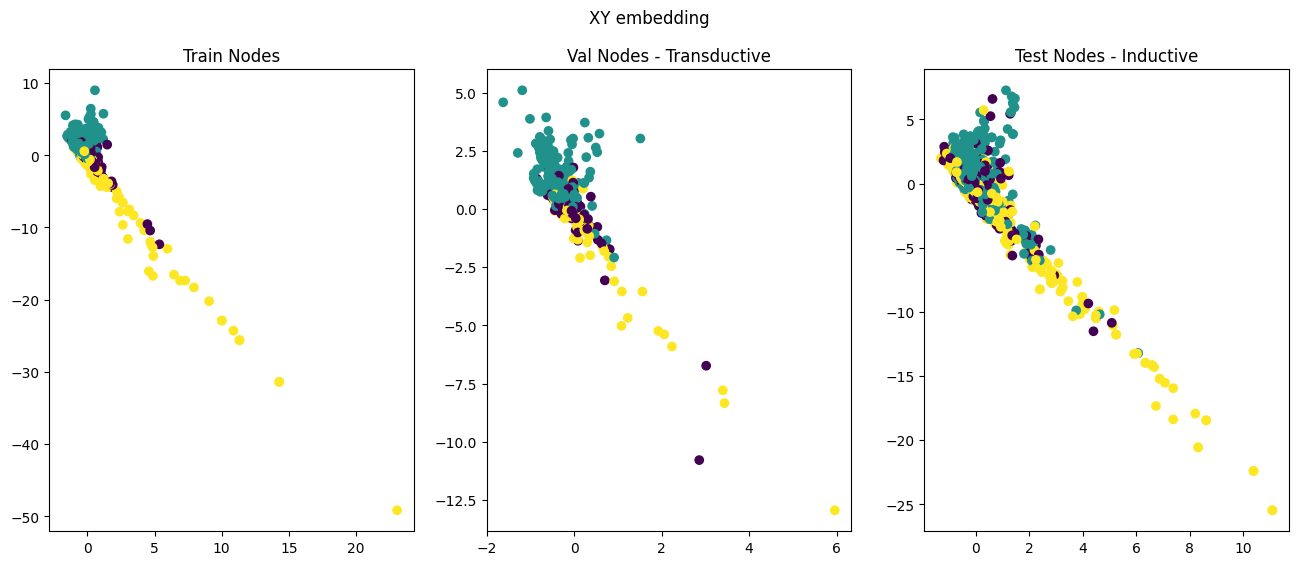

In [112]:
pred_split_prob = SAGE_geom.predictions(split_wholeG_torch, max_prob = False)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6),)
fig.suptitle('XY embedding')

ax1.set_title("Train Nodes")
ax1.scatter(pred_split_prob[train_mask_random,0],pred_split_prob[train_mask_random,1], c = split_wholeG_torch.y[train_mask_random])
ax2.set_title("Val Nodes - Transductive")
ax2.scatter(pred_split_prob[test_mask_random,0],pred_split_prob[test_mask_random,1], c = split_wholeG_torch.y[test_mask_random])
ax3.set_title("Test Nodes - Inductive")
ax3.scatter(pred_split_prob[geom_test_mask_torch,0],pred_split_prob[geom_test_mask_torch,1], c = split_wholeG_torch.y[geom_test_mask_torch])
plt.show()

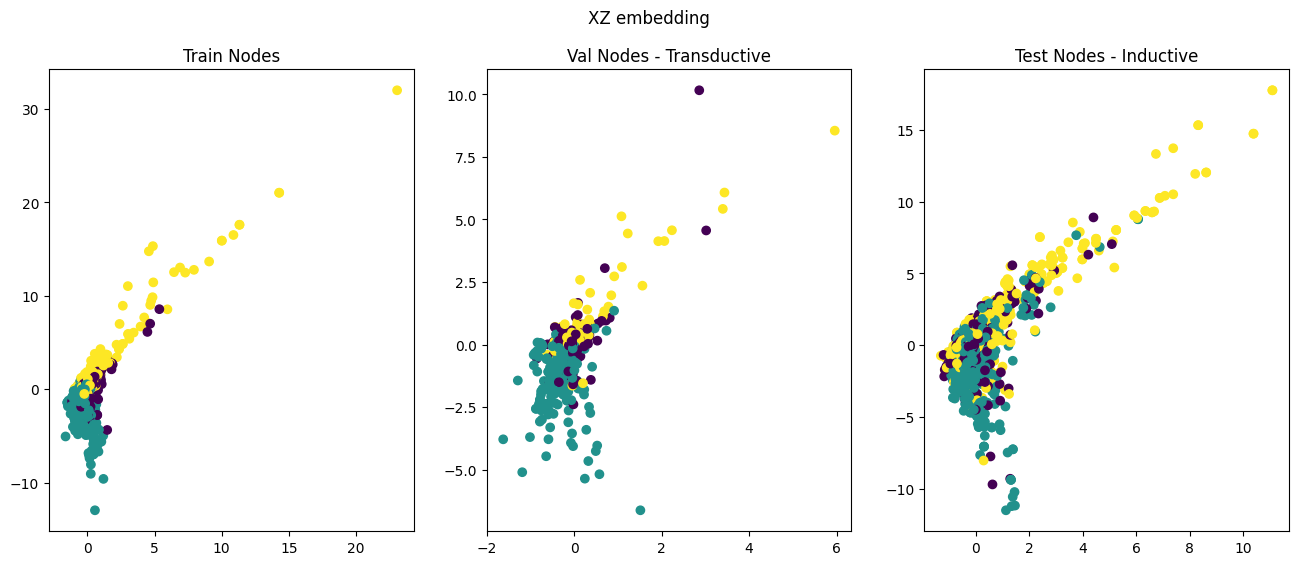

In [113]:
pred_split_prob = SAGE_geom.predictions(split_wholeG_torch, max_prob = False)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6),)
fig.suptitle('XZ embedding')

ax1.set_title("Train Nodes")
ax1.scatter(pred_split_prob[train_mask_random,0],pred_split_prob[train_mask_random,2], c = split_wholeG_torch.y[train_mask_random])
ax2.set_title("Val Nodes - Transductive")
ax2.scatter(pred_split_prob[test_mask_random,0],pred_split_prob[test_mask_random,2], c = split_wholeG_torch.y[test_mask_random])
ax3.set_title("Test Nodes - Inductive")
ax3.scatter(pred_split_prob[geom_test_mask_torch,0],pred_split_prob[geom_test_mask_torch,2], c = split_wholeG_torch.y[geom_test_mask_torch])
plt.show()

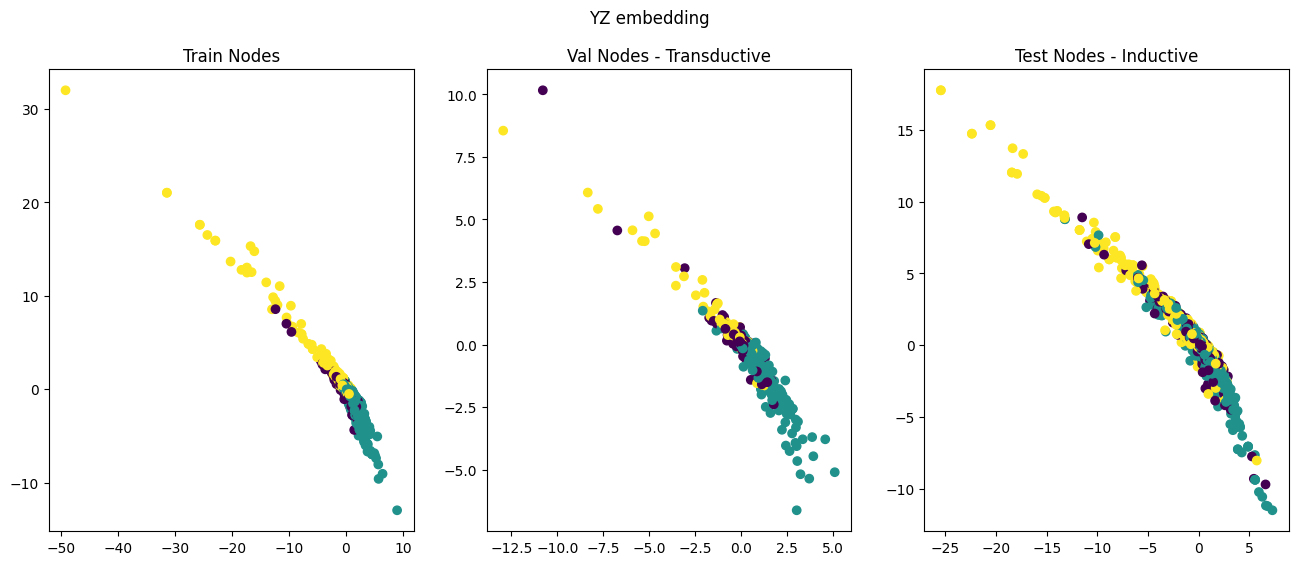

In [117]:
pred_split_prob = SAGE_geom.predictions(split_wholeG_torch, max_prob = False)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6),)
fig.suptitle('YZ embedding')

ax1.set_title("Train Nodes")
ax1.scatter(pred_split_prob[train_mask_random,1],pred_split_prob[train_mask_random,2], c = split_wholeG_torch.y[train_mask_random])
ax2.set_title("Val Nodes - Transductive")
ax2.scatter(pred_split_prob[test_mask_random,1],pred_split_prob[test_mask_random,2], c = split_wholeG_torch.y[test_mask_random])
ax3.set_title("Test Nodes - Inductive")
ax3.scatter(pred_split_prob[geom_test_mask_torch,1],pred_split_prob[geom_test_mask_torch,2], c = split_wholeG_torch.y[geom_test_mask_torch])
plt.show()

In [115]:
from sklearn import manifold
from numpy.random import RandomState
rng = RandomState(0)

t_sne = manifold.TSNE(
    n_components=2,
    learning_rate="auto",
    perplexity=30,
    n_iter=250,
    init="random",
    random_state=rng,
)

S_t_sne_train = t_sne.fit_transform(pred_split_prob[train_mask_random])
S_t_sne_val = t_sne.fit_transform(pred_split_prob[test_mask_random])
S_t_sne_test = t_sne.fit_transform(pred_split_prob[geom_test_mask_torch])

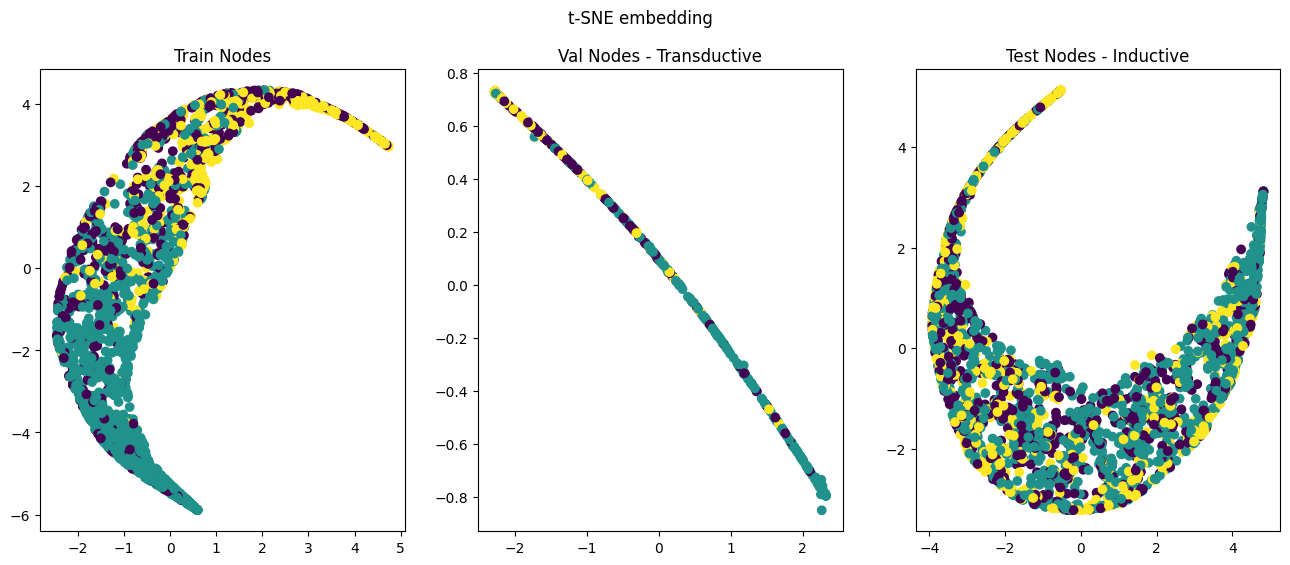

In [118]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6),)
fig.suptitle('t-SNE embedding')

ax1.set_title("Train Nodes")
ax1.scatter(S_t_sne_train[:,0], S_t_sne_train[:,1],c = split_wholeG_torch.y[train_mask_random])
ax2.set_title("Val Nodes - Transductive")
ax2.scatter(S_t_sne_val[:,0], S_t_sne_val[:,1],c = split_wholeG_torch.y[test_mask_random])
ax3.set_title("Test Nodes - Inductive")
ax3.scatter(S_t_sne_test[:,0], S_t_sne_test[:,1],c = split_wholeG_torch.y[geom_test_mask_torch])
plt.show()

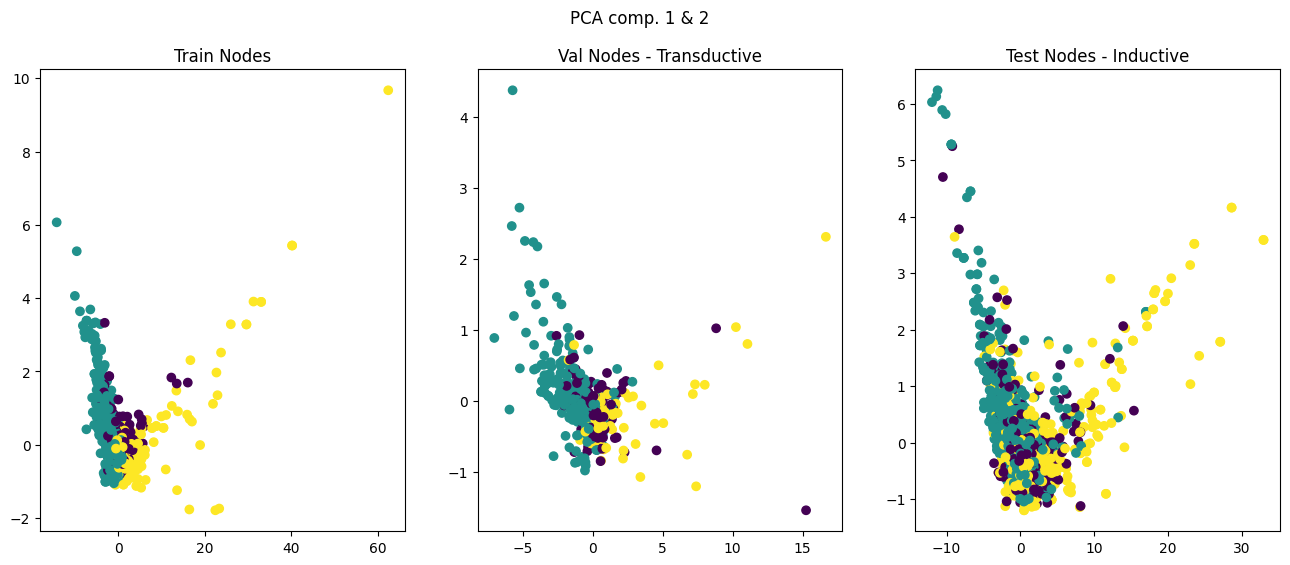

In [131]:

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_transform = pca.fit_transform(pred_split_prob)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6),)
fig.suptitle('PCA comp. 1 & 2')

ax1.set_title("Train Nodes")
ax1.scatter(pca_transform[train_mask_random,0],pca_transform[train_mask_random,1], c = split_wholeG_torch.y[train_mask_random])
ax2.set_title("Val Nodes - Transductive")
ax2.scatter(pca_transform[test_mask_random,0],pca_transform[test_mask_random,1], c = split_wholeG_torch.y[test_mask_random])
ax3.set_title("Test Nodes - Inductive")
ax3.scatter(pca_transform[geom_test_mask_torch,0],pca_transform[geom_test_mask_torch,1], c = split_wholeG_torch.y[geom_test_mask_torch])
plt.show()

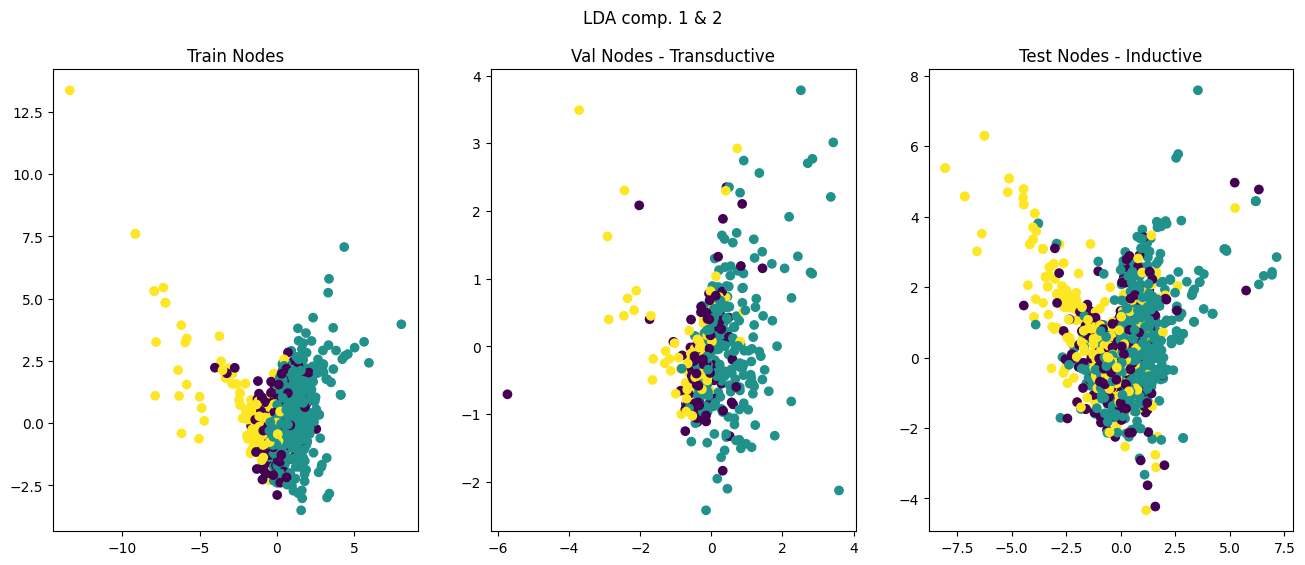

In [132]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
lda_transform = lda.fit(pred_split_prob, split_wholeG_torch.y).transform(pred_split_prob)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6),)
fig.suptitle('LDA comp. 1 & 2')

ax1.set_title("Train Nodes")
ax1.scatter(lda_transform[train_mask_random,0],lda_transform[train_mask_random,1], c = split_wholeG_torch.y[train_mask_random])
ax2.set_title("Val Nodes - Transductive")
ax2.scatter(lda_transform[test_mask_random,0],lda_transform[test_mask_random,1], c = split_wholeG_torch.y[test_mask_random])
ax3.set_title("Test Nodes - Inductive")
ax3.scatter(lda_transform[geom_test_mask_torch,0],lda_transform[geom_test_mask_torch,1], c = split_wholeG_torch.y[geom_test_mask_torch])
plt.show()

In [151]:
#for viridis: 0 is purple, 1 is blue, 2 is yellow ()

#simple classification by threshold
_, train_counts = np.unique(split_wholeG_torch.y[train_mask_random], return_counts = True)

sl_train = split_wholeG_torch.y[train_mask_random][lda_transform[train_mask_random,0] > 0]
_, sl_train_counts = np.unique(sl_train, return_counts = True)

sh_train = split_wholeG_torch.y[train_mask_random][lda_transform[train_mask_random,0] <= 0]
_, sh_train_counts = np.unique(sh_train, return_counts = True)

for i, ct in enumerate(train_counts):
    print(f"count: {ct}")
    print(f"Low:  {sl_train_counts[i]/ct*100:.2f}% versus High: {sh_train_counts[i]/ct*100:.2f}%" )

print("##################")

#simple classification by threshold
_, train_counts = np.unique(split_wholeG_torch.y[test_mask_random], return_counts = True)

sl_train = split_wholeG_torch.y[test_mask_random][lda_transform[test_mask_random,0] > 0]
_, sl_train_counts = np.unique(sl_train, return_counts = True)

sh_train = split_wholeG_torch.y[test_mask_random][lda_transform[test_mask_random,0] <= 0]
_, sh_train_counts = np.unique(sh_train, return_counts = True)

for i, ct in enumerate(train_counts):
    print(f"count: {ct}")
    print(f"Low:  {sl_train_counts[i]/ct*100:.2f}% versus High: {sh_train_counts[i]/ct*100:.2f}%" )

print("##################")

#simple classification by threshold
_, train_counts = np.unique(split_wholeG_torch.y[geom_test_mask_torch], return_counts = True)

sl_train = split_wholeG_torch.y[geom_test_mask_torch][lda_transform[geom_test_mask_torch,0] > 0]
_, sl_train_counts = np.unique(sl_train, return_counts = True)

sh_train = split_wholeG_torch.y[geom_test_mask_torch][lda_transform[geom_test_mask_torch,0] <= 0]
_, sh_train_counts = np.unique(sh_train, return_counts = True)

for i, ct in enumerate(train_counts):
    print(f"count: {ct}")
    print(f"Low:  {sl_train_counts[i]/ct*100:.2f}% versus High: {sh_train_counts[i]/ct*100:.2f}%" )



count: 604
Low:  32.78% versus High: 67.22%
count: 1268
Low:  72.24% versus High: 27.76%
count: 570
Low:  8.07% versus High: 91.93%
##################
count: 110
Low:  27.27% versus High: 72.73%
count: 232
Low:  69.40% versus High: 30.60%
count: 90
Low:  16.67% versus High: 83.33%
##################
count: 695
Low:  34.96% versus High: 65.04%
count: 1420
Low:  54.30% versus High: 45.70%
count: 759
Low:  23.85% versus High: 76.15%


In [121]:
from torch_geometric.nn import GNNExplainer

node_idx = 100
x, edge_index = split_wholeG_torch.x.float(), split_wholeG_torch.edge_index
explainer = GNNExplainer(SAGE_geom.model, epochs=10)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index, training = False)

print(f"Node Class: {split_wholeG_torch.y[node_idx]}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (5x17 and 16x64)

In [ ]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=LX_comb_einf_lab.y)
print(node_feat_mask)
plt.show()